# Drawing your Flamingo with DCGAN

Train a DCGAN using quickdraw flamingo images
Use the DCGAN to draw a flamingo

By Yaohang Li

In [1]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot as plt

## Define Discriminator

In [2]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

## Define Generator

In [3]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

## Define GAN

In [4]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

## Other supportive functions

In [5]:
# load and prepare training images
def load_real_samples():
    trainX = np.load('../NeuralNetwork/flamingo.npy')
    trainX = trainX.reshape(trainX.shape[0], 28, 28)
    plot_samples(trainX, title='Sample flamingo drawings\n')
    print(trainX.shape)
    # expand to 3d, e.g. add channels dimension
    X = expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y
 
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

def plot_samples(input_array, rows=4, cols=5, title=''):
    '''
    Function to plot 28x28 pixel drawings that are stored in a numpy array.
    Specify how many rows and cols of pictures to display (default 4x5).  
    If the array contains less images than subplots selected, surplus subplots remain empty.
    '''    
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
#     save_plot(x_fake, epoch)
    plot_samples(x_fake, title='Sample flamingo drawings\n')
#     # save the generator model tile file
#     filename = 'generator_model_%03d.h5' % (epoch + 1)
#     g_model.save(filename)

## Training

In [6]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 1 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

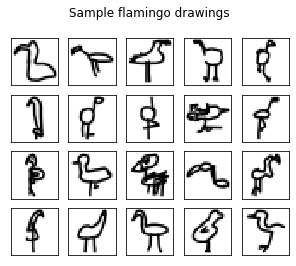

(124569, 28, 28)
>1, 1/486, d=0.696, g=0.707
>1, 2/486, d=0.687, g=0.724
>1, 3/486, d=0.686, g=0.741
>1, 4/486, d=0.675, g=0.756
>1, 5/486, d=0.671, g=0.778
>1, 6/486, d=0.663, g=0.787
>1, 7/486, d=0.657, g=0.804
>1, 8/486, d=0.652, g=0.810
>1, 9/486, d=0.651, g=0.817
>1, 10/486, d=0.650, g=0.814
>1, 11/486, d=0.654, g=0.806
>1, 12/486, d=0.655, g=0.785
>1, 13/486, d=0.664, g=0.771
>1, 14/486, d=0.667, g=0.750
>1, 15/486, d=0.671, g=0.734
>1, 16/486, d=0.667, g=0.722
>1, 17/486, d=0.663, g=0.714
>1, 18/486, d=0.665, g=0.707
>1, 19/486, d=0.656, g=0.702
>1, 20/486, d=0.652, g=0.699
>1, 21/486, d=0.643, g=0.696
>1, 22/486, d=0.641, g=0.695
>1, 23/486, d=0.632, g=0.694
>1, 24/486, d=0.626, g=0.694
>1, 25/486, d=0.619, g=0.694
>1, 26/486, d=0.607, g=0.694
>1, 27/486, d=0.600, g=0.695
>1, 28/486, d=0.593, g=0.695
>1, 29/486, d=0.583, g=0.696
>1, 30/486, d=0.572, g=0.697
>1, 31/486, d=0.562, g=0.698
>1, 32/486, d=0.554, g=0.700
>1, 33/486, d=0.541, g=0.701
>1, 34/486, d=0.528, g=0.702
>1, 35

>1, 278/486, d=0.424, g=0.894
>1, 279/486, d=0.415, g=0.896
>1, 280/486, d=0.409, g=0.908
>1, 281/486, d=0.405, g=0.910
>1, 282/486, d=0.407, g=0.919
>1, 283/486, d=0.399, g=0.924
>1, 284/486, d=0.396, g=0.985
>1, 285/486, d=0.379, g=1.019
>1, 286/486, d=0.373, g=1.059
>1, 287/486, d=0.357, g=1.100
>1, 288/486, d=0.345, g=1.130
>1, 289/486, d=0.340, g=1.134
>1, 290/486, d=0.342, g=1.155
>1, 291/486, d=0.329, g=1.180
>1, 292/486, d=0.325, g=1.164
>1, 293/486, d=0.331, g=1.167
>1, 294/486, d=0.323, g=1.150
>1, 295/486, d=0.327, g=1.149
>1, 296/486, d=0.340, g=1.130
>1, 297/486, d=0.337, g=1.117
>1, 298/486, d=0.347, g=1.118
>1, 299/486, d=0.338, g=1.044
>1, 300/486, d=0.384, g=1.024
>1, 301/486, d=0.388, g=0.996
>1, 302/486, d=0.449, g=0.959
>1, 303/486, d=0.481, g=0.845
>1, 304/486, d=0.601, g=0.698
>1, 305/486, d=0.746, g=0.613
>1, 306/486, d=0.869, g=0.575
>1, 307/486, d=0.930, g=0.686
>1, 308/486, d=0.908, g=0.937
>1, 309/486, d=0.881, g=1.104
>1, 310/486, d=0.891, g=1.201
>1, 311/48

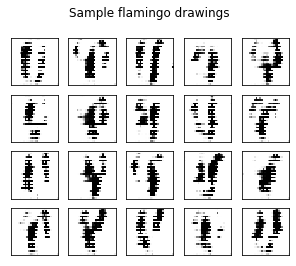

>2, 1/486, d=0.669, g=0.795
>2, 2/486, d=0.655, g=0.805
>2, 3/486, d=0.679, g=0.799
>2, 4/486, d=0.667, g=0.812
>2, 5/486, d=0.679, g=0.818
>2, 6/486, d=0.655, g=0.806
>2, 7/486, d=0.660, g=0.845
>2, 8/486, d=0.663, g=0.838
>2, 9/486, d=0.639, g=0.816
>2, 10/486, d=0.663, g=0.829
>2, 11/486, d=0.640, g=0.794
>2, 12/486, d=0.645, g=0.839
>2, 13/486, d=0.646, g=0.827
>2, 14/486, d=0.630, g=0.831
>2, 15/486, d=0.648, g=0.834
>2, 16/486, d=0.622, g=0.811
>2, 17/486, d=0.620, g=0.810
>2, 18/486, d=0.621, g=0.831
>2, 19/486, d=0.617, g=0.839
>2, 20/486, d=0.630, g=0.861
>2, 21/486, d=0.608, g=0.852
>2, 22/486, d=0.616, g=0.843
>2, 23/486, d=0.621, g=0.837
>2, 24/486, d=0.602, g=0.861
>2, 25/486, d=0.603, g=0.843
>2, 26/486, d=0.621, g=0.853
>2, 27/486, d=0.595, g=0.855
>2, 28/486, d=0.618, g=0.850
>2, 29/486, d=0.615, g=0.835
>2, 30/486, d=0.633, g=0.850
>2, 31/486, d=0.633, g=0.851
>2, 32/486, d=0.621, g=0.845
>2, 33/486, d=0.620, g=0.843
>2, 34/486, d=0.637, g=0.878
>2, 35/486, d=0.628, g=

>2, 278/486, d=0.747, g=0.744
>2, 279/486, d=0.731, g=0.741
>2, 280/486, d=0.709, g=0.771
>2, 281/486, d=0.714, g=0.783
>2, 282/486, d=0.694, g=0.802
>2, 283/486, d=0.678, g=0.827
>2, 284/486, d=0.679, g=0.830
>2, 285/486, d=0.671, g=0.830
>2, 286/486, d=0.650, g=0.849
>2, 287/486, d=0.637, g=0.858
>2, 288/486, d=0.630, g=0.844
>2, 289/486, d=0.618, g=0.842
>2, 290/486, d=0.616, g=0.846
>2, 291/486, d=0.608, g=0.841
>2, 292/486, d=0.599, g=0.820
>2, 293/486, d=0.594, g=0.826
>2, 294/486, d=0.585, g=0.820
>2, 295/486, d=0.589, g=0.817
>2, 296/486, d=0.583, g=0.801
>2, 297/486, d=0.571, g=0.811
>2, 298/486, d=0.554, g=0.816
>2, 299/486, d=0.555, g=0.818
>2, 300/486, d=0.538, g=0.830
>2, 301/486, d=0.542, g=0.831
>2, 302/486, d=0.533, g=0.835
>2, 303/486, d=0.519, g=0.855
>2, 304/486, d=0.526, g=0.838
>2, 305/486, d=0.530, g=0.856
>2, 306/486, d=0.513, g=0.849
>2, 307/486, d=0.531, g=0.824
>2, 308/486, d=0.523, g=0.829
>2, 309/486, d=0.585, g=0.804
>2, 310/486, d=0.592, g=0.781
>2, 311/48

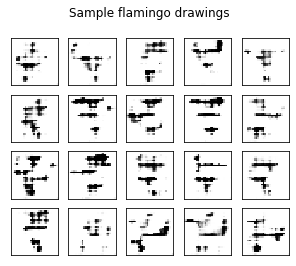

>3, 1/486, d=0.627, g=0.798
>3, 2/486, d=0.644, g=0.783
>3, 3/486, d=0.632, g=0.806
>3, 4/486, d=0.623, g=0.807
>3, 5/486, d=0.610, g=0.809
>3, 6/486, d=0.611, g=0.808
>3, 7/486, d=0.607, g=0.821
>3, 8/486, d=0.598, g=0.819
>3, 9/486, d=0.595, g=0.836
>3, 10/486, d=0.598, g=0.837
>3, 11/486, d=0.609, g=0.832
>3, 12/486, d=0.594, g=0.843
>3, 13/486, d=0.599, g=0.829
>3, 14/486, d=0.610, g=0.828
>3, 15/486, d=0.622, g=0.841
>3, 16/486, d=0.624, g=0.834
>3, 17/486, d=0.627, g=0.835
>3, 18/486, d=0.635, g=0.845
>3, 19/486, d=0.656, g=0.845
>3, 20/486, d=0.661, g=0.867
>3, 21/486, d=0.677, g=0.909
>3, 22/486, d=0.668, g=0.909
>3, 23/486, d=0.679, g=0.908
>3, 24/486, d=0.689, g=0.899
>3, 25/486, d=0.714, g=0.851
>3, 26/486, d=0.736, g=0.776
>3, 27/486, d=0.737, g=0.704
>3, 28/486, d=0.783, g=0.654
>3, 29/486, d=0.811, g=0.610
>3, 30/486, d=0.812, g=0.585
>3, 31/486, d=0.833, g=0.564
>3, 32/486, d=0.826, g=0.564
>3, 33/486, d=0.813, g=0.555
>3, 34/486, d=0.794, g=0.567
>3, 35/486, d=0.800, g=

>3, 278/486, d=0.688, g=0.724
>3, 279/486, d=0.686, g=0.722
>3, 280/486, d=0.683, g=0.731
>3, 281/486, d=0.670, g=0.749
>3, 282/486, d=0.671, g=0.747
>3, 283/486, d=0.679, g=0.749
>3, 284/486, d=0.669, g=0.747
>3, 285/486, d=0.664, g=0.761
>3, 286/486, d=0.667, g=0.770
>3, 287/486, d=0.657, g=0.770
>3, 288/486, d=0.655, g=0.762
>3, 289/486, d=0.656, g=0.746
>3, 290/486, d=0.656, g=0.764
>3, 291/486, d=0.653, g=0.754
>3, 292/486, d=0.648, g=0.752
>3, 293/486, d=0.649, g=0.745
>3, 294/486, d=0.653, g=0.748
>3, 295/486, d=0.640, g=0.757
>3, 296/486, d=0.646, g=0.751
>3, 297/486, d=0.651, g=0.747
>3, 298/486, d=0.653, g=0.755
>3, 299/486, d=0.657, g=0.751
>3, 300/486, d=0.654, g=0.743
>3, 301/486, d=0.656, g=0.741
>3, 302/486, d=0.670, g=0.743
>3, 303/486, d=0.676, g=0.739
>3, 304/486, d=0.691, g=0.742
>3, 305/486, d=0.691, g=0.732
>3, 306/486, d=0.689, g=0.739
>3, 307/486, d=0.698, g=0.726
>3, 308/486, d=0.695, g=0.726
>3, 309/486, d=0.706, g=0.708
>3, 310/486, d=0.715, g=0.705
>3, 311/48

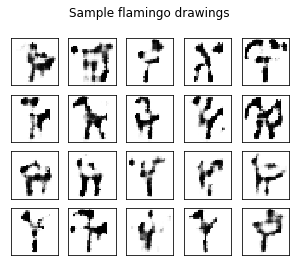

>4, 1/486, d=0.688, g=0.715
>4, 2/486, d=0.683, g=0.707
>4, 3/486, d=0.692, g=0.709
>4, 4/486, d=0.689, g=0.712
>4, 5/486, d=0.687, g=0.702
>4, 6/486, d=0.693, g=0.707
>4, 7/486, d=0.694, g=0.700
>4, 8/486, d=0.687, g=0.706
>4, 9/486, d=0.690, g=0.703
>4, 10/486, d=0.697, g=0.709
>4, 11/486, d=0.686, g=0.710
>4, 12/486, d=0.680, g=0.710
>4, 13/486, d=0.690, g=0.717
>4, 14/486, d=0.690, g=0.709
>4, 15/486, d=0.694, g=0.706
>4, 16/486, d=0.688, g=0.704
>4, 17/486, d=0.688, g=0.715
>4, 18/486, d=0.693, g=0.701
>4, 19/486, d=0.684, g=0.713
>4, 20/486, d=0.685, g=0.714
>4, 21/486, d=0.691, g=0.715
>4, 22/486, d=0.687, g=0.704
>4, 23/486, d=0.679, g=0.721
>4, 24/486, d=0.683, g=0.720
>4, 25/486, d=0.684, g=0.714
>4, 26/486, d=0.679, g=0.724
>4, 27/486, d=0.682, g=0.733
>4, 28/486, d=0.671, g=0.737
>4, 29/486, d=0.671, g=0.747
>4, 30/486, d=0.675, g=0.740
>4, 31/486, d=0.675, g=0.740
>4, 32/486, d=0.665, g=0.742
>4, 33/486, d=0.659, g=0.745
>4, 34/486, d=0.661, g=0.737
>4, 35/486, d=0.665, g=

>4, 278/486, d=0.691, g=0.830
>4, 279/486, d=0.684, g=0.813
>4, 280/486, d=0.701, g=0.810
>4, 281/486, d=0.694, g=0.793
>4, 282/486, d=0.691, g=0.788
>4, 283/486, d=0.690, g=0.779
>4, 284/486, d=0.677, g=0.769
>4, 285/486, d=0.677, g=0.757
>4, 286/486, d=0.671, g=0.756
>4, 287/486, d=0.661, g=0.769
>4, 288/486, d=0.643, g=0.762
>4, 289/486, d=0.630, g=0.771
>4, 290/486, d=0.622, g=0.786
>4, 291/486, d=0.617, g=0.784
>4, 292/486, d=0.605, g=0.786
>4, 293/486, d=0.604, g=0.794
>4, 294/486, d=0.593, g=0.790
>4, 295/486, d=0.590, g=0.786
>4, 296/486, d=0.600, g=0.779
>4, 297/486, d=0.606, g=0.775
>4, 298/486, d=0.620, g=0.761
>4, 299/486, d=0.634, g=0.776
>4, 300/486, d=0.643, g=0.759
>4, 301/486, d=0.649, g=0.786
>4, 302/486, d=0.663, g=0.818
>4, 303/486, d=0.663, g=0.834
>4, 304/486, d=0.664, g=0.851
>4, 305/486, d=0.666, g=0.855
>4, 306/486, d=0.680, g=0.856
>4, 307/486, d=0.682, g=0.818
>4, 308/486, d=0.698, g=0.783
>4, 309/486, d=0.699, g=0.758
>4, 310/486, d=0.730, g=0.725
>4, 311/48

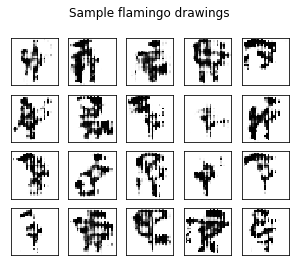

>5, 1/486, d=0.731, g=0.815
>5, 2/486, d=0.719, g=0.828
>5, 3/486, d=0.723, g=0.806
>5, 4/486, d=0.703, g=0.808
>5, 5/486, d=0.699, g=0.812
>5, 6/486, d=0.684, g=0.825
>5, 7/486, d=0.682, g=0.777
>5, 8/486, d=0.669, g=0.779
>5, 9/486, d=0.672, g=0.750
>5, 10/486, d=0.668, g=0.748
>5, 11/486, d=0.667, g=0.744
>5, 12/486, d=0.662, g=0.745
>5, 13/486, d=0.654, g=0.757
>5, 14/486, d=0.646, g=0.768
>5, 15/486, d=0.644, g=0.794
>5, 16/486, d=0.639, g=0.793
>5, 17/486, d=0.628, g=0.799
>5, 18/486, d=0.633, g=0.804
>5, 19/486, d=0.618, g=0.797
>5, 20/486, d=0.620, g=0.791
>5, 21/486, d=0.634, g=0.783
>5, 22/486, d=0.624, g=0.769
>5, 23/486, d=0.635, g=0.771
>5, 24/486, d=0.641, g=0.777
>5, 25/486, d=0.645, g=0.782
>5, 26/486, d=0.641, g=0.787
>5, 27/486, d=0.638, g=0.795
>5, 28/486, d=0.647, g=0.807
>5, 29/486, d=0.654, g=0.780
>5, 30/486, d=0.642, g=0.784
>5, 31/486, d=0.664, g=0.776
>5, 32/486, d=0.661, g=0.770
>5, 33/486, d=0.663, g=0.760
>5, 34/486, d=0.664, g=0.748
>5, 35/486, d=0.666, g=

>5, 278/486, d=0.640, g=0.800
>5, 279/486, d=0.651, g=0.764
>5, 280/486, d=0.660, g=0.775
>5, 281/486, d=0.657, g=0.748
>5, 282/486, d=0.677, g=0.737
>5, 283/486, d=0.683, g=0.720
>5, 284/486, d=0.686, g=0.719
>5, 285/486, d=0.694, g=0.701
>5, 286/486, d=0.689, g=0.721
>5, 287/486, d=0.682, g=0.726
>5, 288/486, d=0.674, g=0.738
>5, 289/486, d=0.681, g=0.742
>5, 290/486, d=0.680, g=0.766
>5, 291/486, d=0.662, g=0.784
>5, 292/486, d=0.650, g=0.799
>5, 293/486, d=0.636, g=0.809
>5, 294/486, d=0.626, g=0.835
>5, 295/486, d=0.617, g=0.838
>5, 296/486, d=0.606, g=0.853
>5, 297/486, d=0.600, g=0.839
>5, 298/486, d=0.585, g=0.867
>5, 299/486, d=0.595, g=0.864
>5, 300/486, d=0.597, g=0.839
>5, 301/486, d=0.600, g=0.849
>5, 302/486, d=0.612, g=0.817
>5, 303/486, d=0.623, g=0.797
>5, 304/486, d=0.635, g=0.762
>5, 305/486, d=0.644, g=0.746
>5, 306/486, d=0.673, g=0.757
>5, 307/486, d=0.694, g=0.750
>5, 308/486, d=0.699, g=0.745
>5, 309/486, d=0.707, g=0.720
>5, 310/486, d=0.717, g=0.710
>5, 311/48

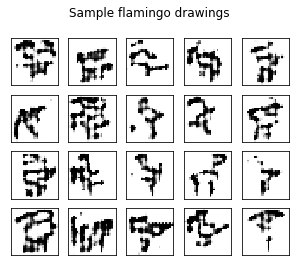

>6, 1/486, d=0.685, g=0.782
>6, 2/486, d=0.685, g=0.834
>6, 3/486, d=0.662, g=0.843
>6, 4/486, d=0.663, g=0.869
>6, 5/486, d=0.644, g=0.886
>6, 6/486, d=0.633, g=0.858
>6, 7/486, d=0.628, g=0.862
>6, 8/486, d=0.627, g=0.831
>6, 9/486, d=0.627, g=0.798
>6, 10/486, d=0.626, g=0.777
>6, 11/486, d=0.622, g=0.765
>6, 12/486, d=0.600, g=0.772
>6, 13/486, d=0.609, g=0.779
>6, 14/486, d=0.594, g=0.794
>6, 15/486, d=0.595, g=0.816
>6, 16/486, d=0.605, g=0.803
>6, 17/486, d=0.622, g=0.799
>6, 18/486, d=0.616, g=0.823
>6, 19/486, d=0.624, g=0.848
>6, 20/486, d=0.644, g=0.859
>6, 21/486, d=0.648, g=0.899
>6, 22/486, d=0.637, g=0.898
>6, 23/486, d=0.652, g=0.885
>6, 24/486, d=0.639, g=0.836
>6, 25/486, d=0.647, g=0.816
>6, 26/486, d=0.668, g=0.788
>6, 27/486, d=0.681, g=0.718
>6, 28/486, d=0.690, g=0.660
>6, 29/486, d=0.702, g=0.660
>6, 30/486, d=0.698, g=0.662
>6, 31/486, d=0.683, g=0.657
>6, 32/486, d=0.664, g=0.696
>6, 33/486, d=0.672, g=0.697
>6, 34/486, d=0.686, g=0.729
>6, 35/486, d=0.681, g=

>6, 278/486, d=0.606, g=0.792
>6, 279/486, d=0.614, g=0.792
>6, 280/486, d=0.618, g=0.813
>6, 281/486, d=0.620, g=0.805
>6, 282/486, d=0.625, g=0.799
>6, 283/486, d=0.632, g=0.760
>6, 284/486, d=0.644, g=0.804
>6, 285/486, d=0.641, g=0.808
>6, 286/486, d=0.651, g=0.777
>6, 287/486, d=0.649, g=0.764
>6, 288/486, d=0.671, g=0.731
>6, 289/486, d=0.666, g=0.748
>6, 290/486, d=0.657, g=0.776
>6, 291/486, d=0.666, g=0.767
>6, 292/486, d=0.660, g=0.779
>6, 293/486, d=0.663, g=0.818
>6, 294/486, d=0.663, g=0.820
>6, 295/486, d=0.642, g=0.776
>6, 296/486, d=0.658, g=0.764
>6, 297/486, d=0.639, g=0.775
>6, 298/486, d=0.631, g=0.809
>6, 299/486, d=0.626, g=0.840
>6, 300/486, d=0.621, g=0.838
>6, 301/486, d=0.628, g=0.854
>6, 302/486, d=0.602, g=0.825
>6, 303/486, d=0.591, g=0.808
>6, 304/486, d=0.606, g=0.813
>6, 305/486, d=0.639, g=0.800
>6, 306/486, d=0.633, g=0.869
>6, 307/486, d=0.632, g=0.843
>6, 308/486, d=0.617, g=0.776
>6, 309/486, d=0.633, g=0.789
>6, 310/486, d=0.619, g=0.768
>6, 311/48

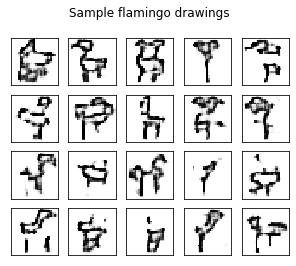

>7, 1/486, d=0.642, g=0.762
>7, 2/486, d=0.645, g=0.756
>7, 3/486, d=0.646, g=0.818
>7, 4/486, d=0.623, g=0.821
>7, 5/486, d=0.635, g=0.786
>7, 6/486, d=0.655, g=0.757
>7, 7/486, d=0.660, g=0.785
>7, 8/486, d=0.630, g=0.852
>7, 9/486, d=0.622, g=0.807
>7, 10/486, d=0.622, g=0.783
>7, 11/486, d=0.632, g=0.791
>7, 12/486, d=0.623, g=0.790
>7, 13/486, d=0.641, g=0.779
>7, 14/486, d=0.645, g=0.775
>7, 15/486, d=0.658, g=0.821
>7, 16/486, d=0.665, g=0.788
>7, 17/486, d=0.658, g=0.762
>7, 18/486, d=0.654, g=0.781
>7, 19/486, d=0.641, g=0.771
>7, 20/486, d=0.645, g=0.774
>7, 21/486, d=0.637, g=0.819
>7, 22/486, d=0.615, g=0.810
>7, 23/486, d=0.630, g=0.811
>7, 24/486, d=0.631, g=0.818
>7, 25/486, d=0.629, g=0.789
>7, 26/486, d=0.637, g=0.794
>7, 27/486, d=0.625, g=0.788
>7, 28/486, d=0.633, g=0.765
>7, 29/486, d=0.637, g=0.750
>7, 30/486, d=0.650, g=0.766
>7, 31/486, d=0.677, g=0.740
>7, 32/486, d=0.661, g=0.735
>7, 33/486, d=0.675, g=0.726
>7, 34/486, d=0.666, g=0.755
>7, 35/486, d=0.668, g=

>7, 278/486, d=0.651, g=0.793
>7, 279/486, d=0.634, g=0.822
>7, 280/486, d=0.636, g=0.782
>7, 281/486, d=0.651, g=0.773
>7, 282/486, d=0.623, g=0.754
>7, 283/486, d=0.629, g=0.819
>7, 284/486, d=0.637, g=0.856
>7, 285/486, d=0.658, g=0.808
>7, 286/486, d=0.658, g=0.769
>7, 287/486, d=0.671, g=0.782
>7, 288/486, d=0.652, g=0.796
>7, 289/486, d=0.681, g=0.781
>7, 290/486, d=0.641, g=0.776
>7, 291/486, d=0.666, g=0.789
>7, 292/486, d=0.659, g=0.756
>7, 293/486, d=0.636, g=0.782
>7, 294/486, d=0.662, g=0.770
>7, 295/486, d=0.638, g=0.792
>7, 296/486, d=0.657, g=0.794
>7, 297/486, d=0.682, g=0.777
>7, 298/486, d=0.661, g=0.741
>7, 299/486, d=0.669, g=0.753
>7, 300/486, d=0.675, g=0.744
>7, 301/486, d=0.686, g=0.756
>7, 302/486, d=0.673, g=0.763
>7, 303/486, d=0.664, g=0.767
>7, 304/486, d=0.649, g=0.793
>7, 305/486, d=0.647, g=0.756
>7, 306/486, d=0.634, g=0.784
>7, 307/486, d=0.657, g=0.809
>7, 308/486, d=0.634, g=0.790
>7, 309/486, d=0.632, g=0.748
>7, 310/486, d=0.637, g=0.839
>7, 311/48

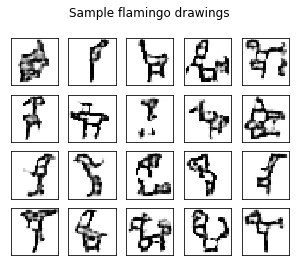

>8, 1/486, d=0.654, g=0.832
>8, 2/486, d=0.667, g=0.800
>8, 3/486, d=0.642, g=0.739
>8, 4/486, d=0.629, g=0.739
>8, 5/486, d=0.647, g=0.838
>8, 6/486, d=0.633, g=0.815
>8, 7/486, d=0.629, g=0.781
>8, 8/486, d=0.635, g=0.741
>8, 9/486, d=0.643, g=0.806
>8, 10/486, d=0.629, g=0.825
>8, 11/486, d=0.666, g=0.811
>8, 12/486, d=0.654, g=0.796
>8, 13/486, d=0.644, g=0.733
>8, 14/486, d=0.666, g=0.797
>8, 15/486, d=0.646, g=0.803
>8, 16/486, d=0.678, g=0.783
>8, 17/486, d=0.660, g=0.792
>8, 18/486, d=0.673, g=0.794
>8, 19/486, d=0.650, g=0.796
>8, 20/486, d=0.635, g=0.776
>8, 21/486, d=0.654, g=0.795
>8, 22/486, d=0.642, g=0.789
>8, 23/486, d=0.645, g=0.790
>8, 24/486, d=0.664, g=0.743
>8, 25/486, d=0.643, g=0.789
>8, 26/486, d=0.659, g=0.806
>8, 27/486, d=0.647, g=0.763
>8, 28/486, d=0.645, g=0.755
>8, 29/486, d=0.635, g=0.766
>8, 30/486, d=0.643, g=0.782
>8, 31/486, d=0.660, g=0.776
>8, 32/486, d=0.637, g=0.783
>8, 33/486, d=0.639, g=0.783
>8, 34/486, d=0.641, g=0.805
>8, 35/486, d=0.645, g=

>8, 278/486, d=0.651, g=0.749
>8, 279/486, d=0.659, g=0.731
>8, 280/486, d=0.657, g=0.816
>8, 281/486, d=0.644, g=0.832
>8, 282/486, d=0.670, g=0.746
>8, 283/486, d=0.655, g=0.762
>8, 284/486, d=0.647, g=0.872
>8, 285/486, d=0.614, g=0.802
>8, 286/486, d=0.641, g=0.774
>8, 287/486, d=0.665, g=0.795
>8, 288/486, d=0.640, g=0.770
>8, 289/486, d=0.666, g=0.757
>8, 290/486, d=0.627, g=0.793
>8, 291/486, d=0.658, g=0.772
>8, 292/486, d=0.660, g=0.791
>8, 293/486, d=0.654, g=0.807
>8, 294/486, d=0.640, g=0.780
>8, 295/486, d=0.653, g=0.785
>8, 296/486, d=0.650, g=0.829
>8, 297/486, d=0.634, g=0.797
>8, 298/486, d=0.657, g=0.792
>8, 299/486, d=0.633, g=0.801
>8, 300/486, d=0.663, g=0.727
>8, 301/486, d=0.676, g=0.791
>8, 302/486, d=0.671, g=0.843
>8, 303/486, d=0.676, g=0.830
>8, 304/486, d=0.657, g=0.811
>8, 305/486, d=0.644, g=0.885
>8, 306/486, d=0.660, g=0.809
>8, 307/486, d=0.619, g=0.771
>8, 308/486, d=0.647, g=0.872
>8, 309/486, d=0.648, g=0.838
>8, 310/486, d=0.632, g=0.735
>8, 311/48

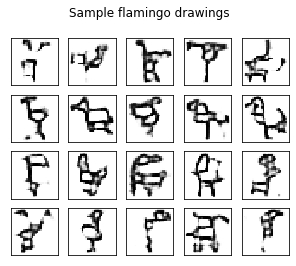

>9, 1/486, d=0.669, g=0.658
>9, 2/486, d=0.644, g=0.795
>9, 3/486, d=0.644, g=0.794
>9, 4/486, d=0.652, g=0.782
>9, 5/486, d=0.640, g=0.839
>9, 6/486, d=0.651, g=0.755
>9, 7/486, d=0.638, g=0.732
>9, 8/486, d=0.666, g=0.857
>9, 9/486, d=0.643, g=0.785
>9, 10/486, d=0.632, g=0.779
>9, 11/486, d=0.687, g=0.736
>9, 12/486, d=0.647, g=0.836
>9, 13/486, d=0.661, g=0.812
>9, 14/486, d=0.659, g=0.767
>9, 15/486, d=0.658, g=0.791
>9, 16/486, d=0.641, g=0.853
>9, 17/486, d=0.630, g=0.816
>9, 18/486, d=0.651, g=0.772
>9, 19/486, d=0.627, g=0.785
>9, 20/486, d=0.615, g=0.852
>9, 21/486, d=0.646, g=0.810
>9, 22/486, d=0.643, g=0.767
>9, 23/486, d=0.635, g=0.726
>9, 24/486, d=0.665, g=0.874
>9, 25/486, d=0.647, g=0.824
>9, 26/486, d=0.635, g=0.743
>9, 27/486, d=0.639, g=0.842
>9, 28/486, d=0.626, g=0.837
>9, 29/486, d=0.655, g=0.808
>9, 30/486, d=0.640, g=0.739
>9, 31/486, d=0.644, g=0.866
>9, 32/486, d=0.647, g=0.829
>9, 33/486, d=0.656, g=0.728
>9, 34/486, d=0.672, g=0.801
>9, 35/486, d=0.679, g=

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)